**Name:** Alex Medina

**File:** First test run to create data using PICASO

Before anything, I need these inputs. On my local machine (Windows) the configuration is as such but in an environment like on Newton I need these not

In [16]:
import os
os.environ['picaso_refdata'] = r'C:\Users\Alex\Desktop\Picaso\picaso\reference' #THIS MUST GO BEFORE YOUR IMPORT STATEMENT
os.environ['PYSYN_CDBS'] = r'C:\Users\Alex\Desktop\Picaso\grp\redcat\trds' #this is for the stellar data discussed below.

In [17]:
#General
import numpy as np
import astropy.units as u
import pandas as pd
import argparse
from pathlib import Path
import matplotlib.pyplot as plt

# Picaso
from picaso import justdoit as jdi
from picaso import justplotit as jpi

# Virga
from virga import justdoit as vj
from virga import justplotit as cldplt

# Other
from bokeh.plotting import show, figure
from bokeh.models import Legend
from bokeh.palettes import Category10
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

The purpose of this first test run is as a toy script to learn how to generate data in mass from PICASO. In particular, I keep MARGE in mind, knowing the test, valid, and train structure of MARGE, and what sorts of output I need from PICASO. 

First, I will just do a simple case where I hard code all of the variables, just testing a SINGLE case.

In [18]:
# Opacity database
wave_range = [1.0, 2.5]
opa = jdi.opannection(wave_range=wave_range)
bd = jdi.inputs(calculation='browndwarf')

# Brown dwarf parameters
bd.phase_angle(0) # radians
bd.gravity(gravity=100, gravity_unit=u.Unit('m/s**2'))

# Query from Sonora Grid
sonora_directory = r"C:\Users\Alex\Desktop\Picaso\data\sonora"
Teff = 900
bd.sonora(sonora_directory, Teff)

# For Virga, have to add kz to picaso profile
# Must be the same length as the presssure grid
p = bd.inputs['atmosphere']['profile']['pressure']
# constant Kz;
bd.inputs['atmosphere']['profile']['kz'] = [3e9] * len(p)

# Choosing between cloud and cloud-free case
clouds = False
if clouds:
    metallicity = 1
    mean_mol_weight = 2.2
    virga_directory = r'C:\Users\Alex\Desktop\Picaso\data\virga'  
    
    bd.virga(['Na2S','KCl'], virga_directory, fsed=0.5, mh=metallicity,
             mmw=mean_mol_weight)
        
out = bd.spectrum(opa, full_output=True)

# Converting to F_nu units and regriding ala BD
x, y = out['wavenumber'], out['thermal'] # cm^-1, erg/cm^2/s/cm
x_micron = 1e4/x
flamy = y * 1e-8 # per anstrom instead of per cm

sp = jdi.psyn.ArraySpectrum(x_micron, flamy,
                            waveunits='um',
                            fluxunits='FLAM')
    
sp.convert("um")
sp.convert('Fnu') # erg/cm^2/s/Hz

x = sp.wave # micron
y = sp.flux #erg/cm2/s/Hz

#regrid in wavenumber to constant resolving power R
out['fluxnu'] = y

x, y = jdi.mean_regrid(1e4/x, y, R=300) #wavenumber, erg/cm2/s/Hz
out['regridy'] =  y
out['regridx'] = x

spectra_loc = r"C:\Users\Alex\Desktop\Picaso\data\sonora_spectra\spectra\sp_t900g100nc_m0.0"
son = pd.read_csv(spectra_loc,delim_whitespace=True,
                 skiprows=3,header=None,names=['w','f'])
sonx, sony =  jdi.mean_regrid(1e4/son['w'], son['f'], newx=x)

show(jpi.spectrum([x]*2,[out['regridy'], sony], legend=['PICASO', 'Sonora']
                  ,plot_width=800,x_range=wave_range,y_axis_type='log'))

I've analyzed this a few times now for a few cases changing some variables and it appears to work fine. Now, I am going to use this same strucutre with slightly less hardcoding inside of a method so that I can run multple different cases for comparison.

In [ ]:
# Adding variables as I go

def bd_spectrum(wavmin, wavmax, gravity, Teff,
                species, fsed, mh, mmw, R, kz_value,
                sonora_db, virga_db, clouds):
    """
    
    """
    
    # Opacity database
    wave_range = [wavmin, wavmax]
    opa = jdi.opannection(wave_range=wave_range)
    bd = jdi.inputs(calculation='browndwarf')

    # Brown dwarf parameters
    bd.phase_angle(0) # radians
    bd.gravity(gravity, gravity_unit=u.Unit('m/s**2'))

    # Query from Sonora Grid
    bd.sonora(sonora_db, Teff)

    # For Virga, have to add kz to picaso profile
    # Must be the same length as the presssure grid
    p = bd.inputs['atmosphere']['profile']['pressure']
    bd.inputs['atmosphere']['profile']['kz'] = [float(kz_value)] * len(p)

    # Choosing between cloud and cloud-free case
    if clouds:
        bd.virga(species, virga_db, fsed=fsed, mh=mh, mmw=mmw)
        
    out = bd.spectrum(opa, full_output=True)

    #Converting to F_nu units and regriding ala BD
    x, y = out['wavenumber'], out['thermal'] # cm^-1, erg/cm^2/s/cm
    x_micron = 1e4/x
    flamy = y * 1e-8 # erg/cm^2/s/Å

    sp = jdi.psyn.ArraySpectrum(x_micron, flamy,
                                waveunits='um',
                                fluxunits='FLAM')
    
    sp.convert("um")
    sp.convert('Fnu') # erg/cm^2/s/Hz

    x = sp.wave # micron
    y = sp.flux #erg/cm2/s/Hz

    # regrid in wavenumber to constant resolving power R
    out['fluxnu'] = y

    x, y = jdi.mean_regrid(1e4/x, y, R=R) #wavenumber, erg/cm2/s/Hz
    out['regridy'] =  y
    out['regridx'] = x
    return x, y

The method is good for producing ONE case. But, I configure to produce multiple cases, chosing between a range of:
- Effective temperature
- Gravity
- Sedimentation efficiency
- Eddy diffusion

Things that are kept constant:
- Clouds True of False
- resolution
- metallicity
- cloud species
- mean molecular weight

In [20]:
# =====================
# Configuration
# =====================

sonora_directory = r"C:\Users\Alex\Desktop\Picaso\data\sonora"
virga_directory  = r'C:\Users\Alex\Desktop\Picaso\data\virga'
output_npz       = "test_out2.npz"

use_clouds = True # True to enable Virga f_sed clouds

# I can do a loop of spectrums with range of values
# n_spectra for N different spectra with different values in the parameter space
n_spectra  = 10    # Small to start
seed       = 2

# Wavelength and resolution
wavelength_min  = 1.0
wavelength_max  = 2.5
res_R           = 300   # Tutorial-like grid

# =====================
# Sampling ranges
# =====================

# Temperature
Teff_min   = 700  # K
Teff_max   = 1400 # K
Teff_floor = 500 # K, never sample below this

# Gravity
grav_min   = 50.0 # m/s^2
grav_max   = 1500.0 # m/s^2

# Sedimentation efficiency, dimensionless
fsed_min = 0.5
fsed_max = 5.0

# Eddy diffusion Kz (cm^2/s) 
# Often spans orders of magnitude — sample log-uniform
kz_min = 1e8
kz_max = 3e10


# Cloud microphysics
cloud_species   = ['Na2S','KCl'] # Species
metallicity     = 1.0         # mh
mean_mol_weight = 2.2         # mmw, H2-dominated

Keeping MARGE in mind, result will be saveds as a .npz, with a file structure like:

x: [Teff, fsed]

y: the spectrum on one shared grid

wavelength_um: the shared wavelength axis

In [21]:
# MAIN

def main():

    # Sample Teff and fsed with a random seed
    # Able to reproduce notable results
    rng = np.random.default_rng(seed)

    # Draw n samples of Teff, gravity, fsed, kz
    Teff = rng.uniform(Teff_min, Teff_max, size=n_spectra)
    Teff = np.maximum(Teff, Teff_floor) # Setting hard floor at 500 K

    # Can have log-uniform instead
    grav = rng.uniform(grav_min, grav_max, size=n_spectra)
    # grav = 10 ** rng.uniform(np.log10(g_min), np.log10(g_max), size=n_spectra)

    # kz log-uniform in cm^2/s
    kz = rng.uniform(kz_min, kz_max, size=n_spectra)
    #kz = 10 ** rng.uniform(np.log10(kz_min), np.log10(kz_max), size=n_spectra)

    # fsed
    fsed = rng.uniform(fsed_min, fsed_max, size=n_spectra)

    # First run to lock wavelength grid
    w, f = bd_spectrum(wavelength_min, wavelength_max, grav[0], Teff[0],
                         tuple(cloud_species), fsed[0], metallicity, mean_mol_weight, res_R, kz[0],
                         sonora_directory, virga_directory, use_clouds)
    
    # Checks that every run used the same wavelength grid
    nw = len(w)
    # X holds [Teff, g (m/s^2), f_sed, Kz (cm^2/s)]
    X = np.empty((n_spectra, 4), dtype=np.float32)
    Y = np.empty((n_spectra, nw), dtype=np.float32)

    X[0] = [Teff[0], grav[0], fsed[0], kz[0]]
    Y[0] = f.astype(np.float32)

    # Packs inputs X=[Teff, g, f_sed, Kz] and outputs Y=spectrum
    # Remaining runs
    for i in range(1, n_spectra):
        lam_i, f_i = bd_spectrum(wavelength_min, wavelength_max, grav[i], Teff[i],
                         tuple(cloud_species), fsed[i], metallicity, mean_mol_weight, res_R, kz[i],
                         sonora_directory, virga_directory, use_clouds)
        
        if len(lam_i) != nw or not np.allclose(lam_i, w, atol=1e-8, rtol=0):
            raise RuntimeError("Wavelength grid changed between runs; check PICASO version / regrid settings.")
        
        X[i] = [Teff[i], grav[i], fsed[i], kz[i]]
        Y[i] = f_i.astype(np.float32)

    # Saving in .NPZ format ready for MARGE
    np.savez_compressed(output_npz, x=X, y=Y, wavelength_um=w.astype(np.float32))
    print(f"Saved {output_npz}: X{X.shape}, Y{Y.shape}, wav{w.shape}")
    print("NOTE: Ran cloud version." if use_clouds else "NOTE: Ran cloud-free version.")

In [22]:
if __name__ == "__main__":
    main()

Saved test_out2.npz: X(10, 4), Y(10, 275), wav(275,)
NOTE: Ran cloud version.


To visualize results

In [23]:
# Path the the .NPZ folder

npz_path = Path(r"C:\Users\Alex\Desktop\Picaso\NN_project\test_out2.npz") 
data = np.load(npz_path)

# The file stores:
# x -> inputs [Teff, g, f_sed, Kz] with shape (n_spectra, 4)
# y -> spectra (flux_nu) with shape (n_spectra, n_lambda)
# wavelength_um -> wavelength grid in microns (n_lambda,)
print("Keys:", list(data.keys()))
X = data["x"]
Y = data["y"]
lam = data["wavelength_um"]

n_spectra, n_inputs = X.shape
print(f"X shape: {X.shape}  (columns: Teff[K], g[m/s^2], f_sed[-], Kz[cm^2/s])")
print(f"Y shape: {Y.shape}  (flux_nu per spectrum)")
print(f"lam shape: {lam.shape}  (micron)")

print("\nInput ranges:")
print("  Teff [K]      :", float(X[:,0].min()), "to", float(X[:,0].max()))
print("  g [m/s^2]     :", float(X[:,1].min()), "to", float(X[:,1].max()))
print("  f_sed [-]     :", float(X[:,2].min()), "to", float(X[:,2].max()))
print("  Kz [cm^2/s]   :", float(X[:,3].min()), "to", float(X[:,3].max()))

print("\nFlux stats across all spectra:")
print("  min:", float(Y.min()), " max:", float(Y.max()))


Keys: ['x', 'y', 'wavelength_um']
X shape: (10, 4)  (columns: Teff[K], g[m/s^2], f_sed[-], Kz[cm^2/s])
Y shape: (10, 275)  (flux_nu per spectrum)
lam shape: (275,)  (micron)

Input ranges:
  Teff [K]      : 738.6026611328125 to 1269.9580078125
  g [m/s^2]     : 267.59027099609375 to 1452.7821044921875
  f_sed [-]     : 1.4085835218429565 to 4.480023384094238
  Kz [cm^2/s]   : 3225852416.0 to 27734085632.0

Flux stats across all spectra:
  min: 4.793059282803824e-10  max: 2.776700739559601e-06


In [24]:
# Making a dataframe to visualize

df_inputs = pd.DataFrame(
    X, columns=["Teff_K", "g_mps2", "f_sed", "Kz_cm2s"]
)
# Optional convenience columns for ML/plots:
#df_inputs["log10_g"]  = np.log10(df_inputs["g_mps2"])
#df_inputs["log10_Kz"] = np.log10(df_inputs["Kz_cm2s"])

df_inputs.head(10)

,Teff_K,g_mps2,f_sed,Kz_cm2s
0,883.128479,865.285217,1.408584,1.044422e+10
1,908.943787,267.590271,4.480023,1.538087e+10
2,1269.958008,677.314636,3.559152,2.674716e+10
3,764.341187,1020.481079,4.321563,2.328936e+10
4,1120.070312,663.037781,3.399963,9.612583e+09
5,1209.992310,968.117371,2.329441,2.773409e+10
6,831.530762,1452.782104,2.824602,1.418021e+10
7,738.602661,1040.443970,3.170496,2.084339e+10
8,892.478577,617.856018,4.379531,3.305499e+09
9,1160.203125,321.516235,2.471838,3.225852e+09


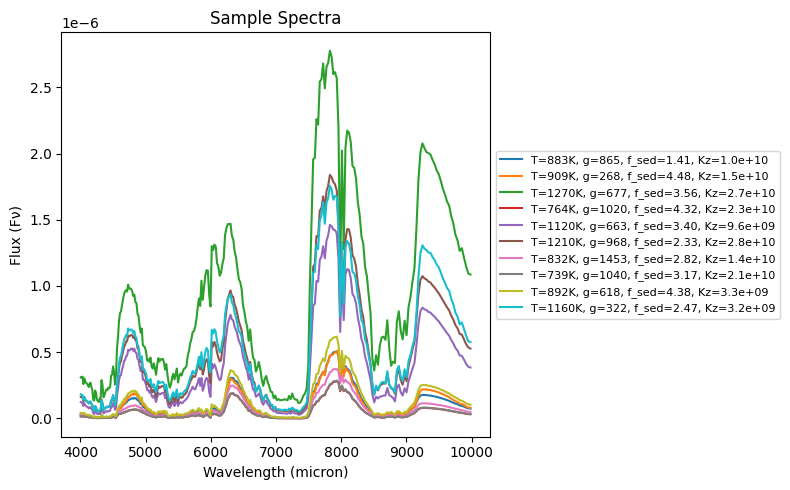

In [25]:
# Plot to see the resulting spectra

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for i in range(n_spectra):
    teff_i = X[i, 0]
    g_i    = X[i, 1]
    fsed_i = X[i, 2]
    kz_i   = X[i, 3]
    label = f"T={teff_i:.0f}K, g={g_i:.0f}, f_sed={fsed_i:.2f}, Kz={kz_i:.1e}"
    plt.plot(lam, Y[i], label=label)

plt.xlabel("Wavelength (micron)")
plt.ylabel("Flux (Fν)")
plt.title("Sample Spectra")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8)
plt.tight_layout()
plt.show()


In [26]:
# If not already imported in your notebook:
# from bokeh.plotting import figure, show
# from bokeh.models import Legend
# from bokeh.palettes import Category10

palette = Category10[10]  # 10 distinct colors
colors = [palette[i % len(palette)] for i in range(n_spectra)]

p = figure(width=700, height=400,
           x_axis_label="Wavelength (micron)",
           y_axis_label="Flux (Fν)",
           title="Sample Spectra")

legend_items = []

for i in range(n_spectra):
    teff_i = X[i, 0]
    g_i    = X[i, 1]
    fsed_i = X[i, 2]
    kz_i   = X[i, 3]
    label = f"T={teff_i:.0f}K, g={g_i:.0f}, f_sed={fsed_i:.2f}, Kz={kz_i:.1e}"
    r = p.line(lam, Y[i], line_width=2, color=colors[i])
    legend_items.append((label, [r]))

legend = Legend(items=legend_items, location="center")
p.add_layout(legend, 'right')
p.legend.label_text_font_size = "8pt"

show(p)